## Machine translation using encoder-decoder Sequence to Sequence Architecture

This notebook demonstrate the machine translation from english to hindi language. Though the same model can be used for translating input into any other language

### Pre-requisites

- Download the data: http://www.manythings.org/anki/
- Download the word vectors: http://nlp.stanford.edu/data/glove.6B.zip

In [1]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


In [2]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

W0923 14:10:07.126000 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0923 14:10:07.127454 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0923 14:10:07.128545 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0923 14:10:07.160377 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

In [3]:
# Configuration

BATCH_SIZE=64              # Batch size for training.
EPOCHS = 25                # Number of epochs to train for.
LATENT_DIM = 256           # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000        # Number of samples to train on
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
# Where we will store the data
input_texts = []          # sentence in original language
target_texts = []         # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

### Prepare training data

In [5]:
t = 0
for line in open('data/hin-eng/hin.txt'):
    # only keep a limited number of samples.
    t += 1
    if t > NUM_SAMPLES:
        break
        
    # input and target are separated by tab
    if '\t' not in line:
        continue
        
    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')
    
    # make the target input and output using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("Number of samples:", len(input_texts))

Number of samples: 2808


### Tokenize the inputs (Convert the sentences (string) into integers)

In [6]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

### Word to integer mapping for input text

In [7]:
# # get the word to index/integer mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found {} unique input tokens.'.format(len(word2idx_inputs)))

for x in list(word2idx_inputs)[1:10]:
    print('{}: {}'.format(x, word2idx_inputs[x]))

Found 2388 unique input tokens.
i: 2
to: 3
you: 4
is: 5
a: 6
he: 7
of: 8
in: 9
my: 10


In [8]:
# Determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

print('max_len_input:', max_len_input)

max_len_input: 22


### Tokenize the output (Convert the sentences (string) into integers)

In [9]:
# We don't filter out special characters, otherwise <eos> and <sos> won't appear.
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
# This is an inefficient way as we are tokenizing it on the same data (target_texts and target_texts_input)
# just offset by <sos> and <eos>word2idx_outputs
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_input = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

### Word to integer mapping for output texts

In [10]:
# get the word to index mapping for output/translated language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' %len(word2idx_outputs))

for x in list(word2idx_outputs)[1:10]:
    print('{}: {}'.format(x, word2idx_outputs[x]))

Found 3138 unique output tokens.
<sos>: 2
है।: 3
में: 4
नहीं: 5
मैं: 6
वह: 7
से: 8
के: 9
मुझे: 10


In [11]:
# store number of output words for later. remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
print('num_words_output:', num_words_output)

# determine the maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print ('Maximum length of target/translated text is:', max_len_target)

num_words_output: 3139
Maximum length of target/translated text is: 26


### Pad Sequences

In [12]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_inputs.shape:', encoder_inputs.shape)
print('encoder_inputs[0]:', encoder_inputs[0])

encoder_inputs.shape: (2808, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1274]


In [13]:
decoder_inputs = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')
# 26 is the maximum length of the sentence in the translated data in the training set
print('decoder_inputs.shape:', decoder_inputs.shape)
print('decoder_inputs[0]:', decoder_inputs[0])

decoder_inputs.shape: (2808, 26)
decoder_inputs[0]: [   2 1486    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [14]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print('decoder_targets.shape:', decoder_targets.shape)
print('decoder_targets[0]:', decoder_targets[0])

decoder_targets.shape: (2808, 26)
decoder_targets[0]: [1486    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Load pre-trained word vectors - Embeddings

In [15]:
print('Loading word vectors')
word2vec = {}
# Load word vector of 100 dimensions.
with open (os.path.join('Embeddings/glove.6B/glove.6B.%sd.txt' %EMBEDDING_DIM)) as f:
    for line in f:
        # split at spaces
        values = line.split()
        word = values[0]
        #np.asarray Converts the input to an array.
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
print('Found %s word vectors.' %len(word2vec))
print('Embedding dimensions: ', word2vec['the'].shape)

Loading word vectors
Found 400000 word vectors.
Embedding dimensions:  (100,)


### Prepare Embedding matrix

In [16]:
print('Filling pre-trained embeddings')
# MAX_NUM_WORDS = 20000
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not foun20000d in the embedding index will all be zero
            embedding_matrix[i] = embedding_vector

print('num_words:', num_words)
# 2389 words each of 100 dimensions
print('Shape of Embeddings matrix: ', embedding_matrix.shape)

Filling pre-trained embeddings
num_words: 2389
Shape of Embeddings matrix:  (2389, 100)


### Embedding layer

In [17]:
embedding_layer = Embedding(num_words, 
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = max_len_input,
                           #trainable=true
                           )

W0923 14:10:42.892149 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Build Encoder-decoder LSTM model

In [19]:
encoder_inputs_placeholder = Input(shape=(max_len_input, ))
x = embedding_layer(encoder_inputs_placeholder)

encoder_lstm = LSTM(
    LATENT_DIM,
    return_state=True,
    dropout=0.5
)

encoder_outputs, h, c = encoder_lstm(x)

# keep only the states to pass into decoder
encoder_states = [h,c]

# setup the decoder, using [h,c] as initial state
decoder_inputs_placeholder = Input(shape=(max_len_target, ))

# this word embedding will not use pre-trained vectors although we could
decoder_embedding_layer = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs_placeholder)

decoder_lstm = LSTM(
        LATENT_DIM, 
        return_sequences=True,
        return_state=True,
        dropout = 0.5
    )

decoder_outputs, _, _ = decoder_lstm(
                          decoder_inputs_x,
                          initial_state=encoder_states
                        )

print('num_words_output:', num_words_output)

# Final dense layers
decoder_dense  = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

W0923 14:10:43.205837 139967626438464 deprecation.py:506] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


num_words_output: 3139


### Compile the model

In [20]:
model.compile(
        optimizer = 'rmsprop',
        loss='categorical_crossentropy',
        metrics=['acc'])

W0923 14:10:43.649616 139967626438464 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training Model

In [21]:
history = model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

W0923 14:10:43.834923 139967626438464 deprecation.py:323] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2246 samples, validate on 562 samples
Epoch 1/25
2246/2246 [==============================] - 24s 11ms/step - loss: 2.4617 - acc: 0.7137 - val_loss: 2.9174 - val_acc: 0.5845
Epoch 2/25
2246/2246 [==============================] - 15s 7ms/step - loss: 1.5936 - acc: 0.7522 - val_loss: 2.7950 - val_acc: 0.5924
Epoch 3/25
2246/2246 [==============================] - 17s 8ms/step - loss: 1.4798 - acc: 0.7728 - val_loss: 2.7081 - val_acc: 0.6254
Epoch 4/25
2246/2246 [==============================] - 18s 8ms/step - loss: 1.4114 - acc: 0.7787 - val_loss: 2.7570 - val_acc: 0.6296
Epoch 5/25
2246/2246 [==============================] - 16s 7ms/step - loss: 1.3581 - acc: 0.7835 - val_loss: 2.6532 - val_acc: 0.6330
Epoch 6/25
2246/2246 [==============================] - 17s 7ms/step - loss: 1.3092 - acc: 0.7883 - val_loss: 2.6305 - val_acc: 0.6382
Epoch 7/25
2246/2246 [==============================] - 15s 7ms/step - loss: 1.2650 - acc: 0.7917 - val_loss: 2.6129 - val_acc: 0.6393
Epoch 8

### Visualize accuracy and loss curves

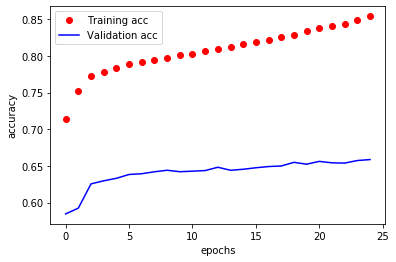

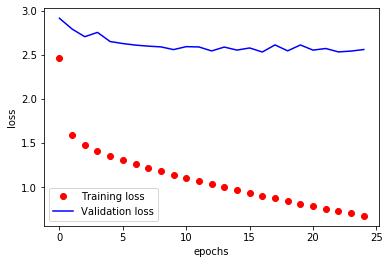

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc_machine_translation_lstm.png')
plt.show()
plt.clf()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('static/loss_machine_translation_lstm.png')
plt.show()
plt.clf()

### Make predictions

In [23]:
# create another model that can take in the RNN state and previous word as input and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [24]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [25]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I can't walk any further.
Translation: मैं नहीं आ सकता।
Continue? [Y/n]Y
-
Input: There were two murders this month.
Translation: इस दो दो दो कम घंटे हैं।
Continue? [Y/n]Y
-
Input: They were scolded by the teacher.
Translation: वे अपने देश को तैरकर अंडे दिया।
Continue? [Y/n]Y
-
Input: Will you sing me a Beatles' song?
Translation: तुम अपनी एक एक एक बीटल्स का क्या?
Continue? [Y/n]Y
-
Input: I've never met her, but I recognize her.
Translation: मेरे पास उसकी पैसे करने के लिए मन था।
Continue? [Y/n]n
